### Задачи к Лекции 4

__Исходные данные__ 

Дан файл **"mlbootcamp5_train.csv"**. В нем содержатся данные об опросе 70000 пациентов с целью определения наличия заболеваний сердечно-сосудистой системы (ССЗ). Данные в файле промаркированы и если у человека имееются ССЗ, то значение **cardio** будет равно 1, в противном случае - 0. Описание и значения полей представлены во второй лекции.

__Загрузка файла__

In [22]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


df = pd.read_csv("../data/mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
# Делаем one-hot кодирование
chol = pd.get_dummies(df["cholesterol"], prefix="chol")
gluc = pd.get_dummies(df["gluc"], prefix="gluc")
df = pd.concat([df, chol, gluc], axis=1)

# Делаем пол бинарным признаком
df["gender_bin"] = df["gender"].map({1: 0, 2: 1})
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,chol_1,chol_2,chol_3,gluc_1,gluc_2,gluc_3,gender_bin
id,,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,1,0,0,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,0,0,1,1,0,0,0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,0,0,1,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,1,0,0,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,1,0,0,1,0,0,0


## Задачи

__1. Хоть в sklearn и присутствует реализация метода k-ближайших соседей, я же предлагаю попробовать вам написать его самостоятельно.__

* __создать классификатор используя только pandas, numpy и scipy. Гиперпараметром данного классификатора должно быть число ближайших соседей. (Необязательно) можно добавить метрику расстояния и выбор весов.__
* __С помощью кросс-валидации найти оптимальное количество ближайших соседей и (необязательно) набор признаков.__

Алгоритм работы классификатора:
 1. Для заданного прецедент  $\vec{x}$ мы считаем расстояние до всех прецедентов в обучающей выборке.
 2. Сортируем прецеденты по расстоянию до $\vec{x}$.
 3. Отбираем $k$ минимальных значений
 4. Устраиваем голосование между отобранными прецедент.

In [23]:
class SimpleKnn:
    """
        Простейшая реализация kNN. Довольно медленно работает на больших объемах данных.
    """
    def __init__(self, k): 
        self.k = k
        self.data = None
        
        # Это нам понадобиться для масштабирования новых данных
        self.means = None
        self.stds = None
        
        self.target = None
        
    def set_k(self, k):
        self.k = k
    
    def fit(self, X, Y):
        """
            Принимаем только массивы от numpy
        """
        if not isinstance(X, np.ndarray) or not isinstance(Y, np.ndarray):
            raise Exception("Invalid array")
        
        if X.shape[0] != Y.shape[0]:
            raise Exception("Invalid shapes")
        
        if len(Y.shape) > 1:
            raise Exception("Invalid target shape")
            
        # Нормализуем данные
        self.means = X.mean(axis=0)
        self.stds = X.std(axis=0)   
        
        self.data = (X - self.means) / self.stds
        self.target = Y
    
    def _predict(self, row):
        # считаем обычное расстояние 
        distances = np.sum((self.data - row)**2, axis=1)  
        
        # Находим индексы отсортированного массива
        idx = np.argsort(distances)
        
        # и смотрим k первых                
        vote = 0
        for i in idx[:self.k]:
            vote += 1 if self.target[i] else -1
        if vote >= 0:
            return 1
        else:
            return 0
        
    
    def predict(self, X):
        # Сразу же нормируем
        X = (X - self.means) / self.stds
        
        results = np.zeros(X.shape[0])
        for i, row in enumerate(X):
            results[i] = self._predict(row)
            
        return results

In [24]:
from sklearn.model_selection import train_test_split

# Убираем последний столбец в данных для анализа
data = df.drop('cardio', axis=1).values

# Наши исходы
target = df['cardio'].values

data_train, data_test, target_train, target_test = train_test_split(   
    data, target, 
    test_size=0.3,
)

Проверим, что он работает

In [4]:
knn = SimpleKnn(5)
knn.fit(data_train, target_train)
print("Predict = %d\nTarget = %d" % (knn._predict(data_test[0]), target_test[0]))

Predict = 0
Target = 0


In [5]:
%%time

from sklearn.metrics import accuracy_score

knn = SimpleKnn(5)
knn.fit(data_train, target_train)

# Ограничиваем выборку, т.к. наивная реализация будет работать крайне медленно
N = 2000
print("Accuracy = %f" % (accuracy_score(target_test[:N], knn.predict(data_test[:N]))))

Accuracy = 0.642000
CPU times: user 12.9 s, sys: 2.01 s, total: 14.9 s
Wall time: 15.3 s


Возьмем за эталон оптимизированный класс из sklearn

In [6]:
%%time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(5))
pipe.fit(data_train, target_train)
cv = pipe.predict(data_test)
accuracy_score(target_test, cv)

CPU times: user 20.9 s, sys: 7.77 s, total: 28.7 s
Wall time: 26.1 s


0.653

А теперь найдем оптимальное количество соседей.

In [9]:
%%time

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

knn = SimpleKnn(1)

# Просто создаю генератор фолдов
kf = KFold(n_splits=2, shuffle=True, random_state=13)
#kf = StratifiedKFold(n_splits=2, random_state=13)

K = np.arange(1, 100, 1)
acc = np.zeros(K.shape)
f1 = np.zeros(K.shape)

for train_index, test_index in kf.split(data[:5000], target[:5000]):
    data_train, data_test = data[train_index], data[test_index]
    target_train, target_test = target[train_index], target[test_index]

    knn.fit(data_train, target_train)
    
    for i, k in enumerate(K):
        knn.set_k(k)
        cv = knn.predict(data_test)        
        acc[i] += accuracy_score(target_test, cv)
        f1[i] += f1_score(target_test, cv)

acc = acc / kf.get_n_splits()
f1 = f1 / kf.get_n_splits()

CPU times: user 2min 17s, sys: 1.17 s, total: 2min 18s
Wall time: 2min 21s


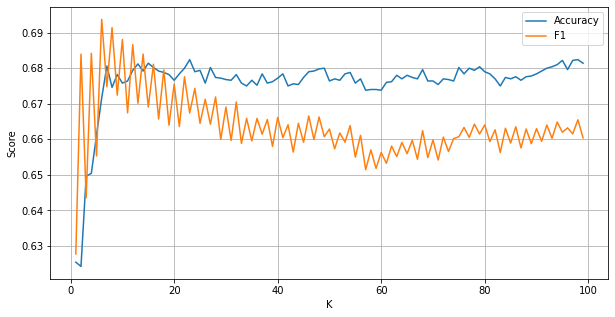

In [10]:
plt.figure(figsize=(10, 5))
plt.xlabel("K")
plt.ylabel("Score")
plt.plot(K, acc, label="Accuracy")
plt.plot(K, f1, label="F1")
plt.legend()
plt.grid()
plt.show()

**2. Нужно с помощью кросс-валидации найти оптимальный набор признаков для обычного дерева и метода k-ближайших соседей. Показать и объяснить, как данный набор был получен.**

**3. Для набора признаков полученных в предыдущей задаче, с помощью кросс-валидации найти оптимальный набор гиперпараметров.**

In [25]:
# Решаем обе задачи за раз
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# пул признаков
features = [
    'age', 'height', 'weight', 'ap_hi', 'ap_lo', 
    'smoke', 'alco', 'active',
    'chol_1', 'chol_2', 'chol_3',
    'gluc_1', 'gluc_2', 'gluc_3', 
    'gender_bin'
]





knn_grid = GridSearchCV(
    knn, knn_params, scoring='accuracy',
    cv=3, refit=False,
)


def Greed(df, clf, params, pool):
    
    grid = GridSearchCV(
        clf, params, scoring='accuracy',
        cv=3, refit=False,
    )
    
    # Последнее лучшая подсчитанная метрика
    last_score = 0
    best_features = []
    best_params = None
    while True:
        next_feature = None
        for feature in pool:
            current_features = best_features + [feature,]
            result = grid.fit(df[current_features].values, df['cardio'].values)

            # Сохраням, если результат лучше, чем был
            if last_score < grid.best_score_:
                print("=>", "%s = (%s | %s)\t" % (current_features, grid.best_score_, grid.best_params_))
                next_feature = feature 
                last_score = grid.best_score_
                best_params = grid.best_params_

        if next_feature is None:
            break
        i = features.index(next_feature)
        best_features.append(features[i])
        del features[i]
    
    return last_score, best_features, best_params

In [13]:
tree = DecisionTreeClassifier(random_state=13)
tree_params = {
    'max_depth': np.arange(1, 15, 1),
    'min_samples_split': np.linspace(0.01, 0.5, 10),
}
Greed(df, tree, tree_params, features)

=> ['age'] = (0.5974713994279557 | {'max_depth': 7, 'min_samples_split': 0.06444444444444444})	
=> ['ap_hi'] = (0.7138428527404068 | {'max_depth': 1, 'min_samples_split': 0.01})	
=> ['ap_hi', 'age'] = (0.7215285892738383 | {'max_depth': 4, 'min_samples_split': 0.06444444444444444})	
=> ['ap_hi', 'chol_3'] = (0.7257428494800046 | {'max_depth': 2, 'min_samples_split': 0.01})	
=> ['ap_hi', 'chol_3', 'age'] = (0.7289714480523631 | {'max_depth': 5, 'min_samples_split': 0.06444444444444444})	
=> ['ap_hi', 'chol_3', 'age', 'height'] = (0.7289857174403572 | {'max_depth': 6, 'min_samples_split': 0.01})	
=> ['ap_hi', 'chol_3', 'age', 'weight'] = (0.7298714480527305 | {'max_depth': 5, 'min_samples_split': 0.01})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo'] = (0.730371416624812 | {'max_depth': 5, 'min_samples_split': 0.01})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo', 'weight'] = (0.7310714290738995 | {'max_depth': 5, 'min_samples_split': 0.01})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo', 'gender_bin'] = (0.731

(0.7327857092787595,
 ['ap_hi',
  'chol_3',
  'age',
  'ap_lo',
  'gender_bin',
  'gluc_3',
  'active',
  'gluc_2'],
 {'max_depth': 9, 'min_samples_split': 0.01})

In [ ]:
# Без нормализации
knn = KNeighborsClassifier()
knn_params = {
    'p': [1, 2],
    'n_neighbors': np.arange(1, 15, 1),
}
Greed(df, knn, knn_params, features)

=> ['age'] = (0.5660571277822795 | {'n_neighbors': 14, 'p': 1})	
=> ['ap_hi'] = (0.7138857031486839 | {'n_neighbors': 11, 'p': 1})	


In [ ]:
from sklearn.pipeline import make_pipeline
# С нормализацией (не оптимально)
knn = make_pipeline(
    StandardScaler(), 
    KNeighborsClassifier(),
)
knn_params = {
    'kneighborsclassifier__p': [1, 2],
    'kneighborsclassifier__n_neighbors': np.arange(1, 15, 1),
}
Greed(df, knn, knn_params, features)

**3. Определить какой из трех классификаторов (kNN, наивный Байес, решающее дерево) лучший в каждой метрике по отдельности: accuracy, F1-мера, ROC AUC, Logloss. Использовать набор признаков: 'age', 'weight', 'height', 'ap_lo', 'ap_hi'.**

**(Необязательно) Найти оптимальный набор признаков.**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


features = ['age', 'weight', 'height', 'ap_lo', 'ap_hi']

data= df[features].values
target = df['cardio'].values

classifiers = [
    ("NB", GaussianNB(), {}),
    ("Knn", make_pipeline(
        StandardScaler(), 
        KNeighborsClassifier()),  {"kneighborsclassifier__n_neighbors": np.arange(7, 30, 2)}),
    ("Tree", DecisionTreeClassifier(), {"max_depth": np.arange(2, 10)}),
]

results = []
for name, classifier, params in classifiers:    
    print(name)
    grid_acc = GridSearchCV(
        classifier, params, scoring='accuracy',
        cv=3, refit=False,        
    )
    grid_acc.fit(data, target)
    print("\tAcc =", grid_acc.best_score_, grid_acc.best_params_)
    
    grid_f1 = GridSearchCV(
        classifier, params, scoring='f1',
        cv=3, refit=False,        
    )
    grid_f1.fit(data, target)
    print("\tF1 =", grid_f1.best_score_, grid_f1.best_params_)
    
    grid_roc = GridSearchCV(
        classifier, params, scoring='roc_auc',
        cv=3, refit=False,        
    )
    grid_roc.fit(data, target)
    print("\tROC AUC =", grid_roc.best_score_, grid_roc.best_params_)
    
    grid_logloss = GridSearchCV(
        classifier, params, scoring='neg_log_loss',
        cv=3, refit=False,        
    )
    grid_logloss.fit(data, target)
    print("\tLogloss =", grid_logloss.best_score_, grid_logloss.best_params_)
    
    results.append((
        name, 
        grid_f1.best_score_, grid_acc.best_score_, grid_roc.best_score_, grid_logloss.best_score_,
    ))


print()    

dr = pd.DataFrame(results, columns=["Name", "F1", "Accuracy", "ROC AUC", "Logloss"])
print("Accuracy\n", dr.sort_values(by="Accuracy")[-1:])
print()
print("F1\n", dr.sort_values(by="F1")[-1:])
print()
print("ROC AUC\n", dr.sort_values(by="ROC AUC")[-1:])
print()
print("Logloss\n", dr.sort_values(by="Logloss")[-1:])
print()

dr